# Knife Edge Experiments 4/3/2019

In [1]:
## Packages
'''Import all the necessary packages and modules'''
import pandas as pd
from pycroscopy.io.translators.df_utils.dm_utils import read_dm3
import numpy as np # package for playing with matrices
import matplotlib.pyplot as plt
import sys, os # python modules for interacting with computer
from sklearn.decomposition import PCA
from tkinter import filedialog # interface for opening a file explorer
from tkinter import * # * imports all files in tkinter
import glob
from sklearn import preprocessing
from sklearn.cluster import KMeans

C:\Users\kbs1\AppData\Local\Continuum\anaconda3\envs\peabody\lib\site-packages\pycroscopy\__init__.py:31: FutureWarning: Contents of pycroscopy.core such as hdf_utils, plot_utils have been moved to pyUSID but will continue to be available implicitly till the next release. Please update import statements to import such modules directly frompyUSID. See - https://pycroscopy.github.io/pycroscopy/whats_new.html under June 28 2018
  'pyUSID. See - https://pycroscopy.github.io/pycroscopy/whats_new.html under June 28 2018', FutureWarning)


In [218]:
## Data Directory GUI
'''Getting data directory so data can easily be imported '''
def get_dir(new=True):
    '''Opens a window to select directory if new==False gets current directory
    Returns the directory as a string
    '''
    if new==True:
        root = Tk() # Tk() is a function in tkinter that opens a window
        root.directory = filedialog.askdirectory() # opens explorer window so you can find the folder of choice
        root.withdraw() # closes the tkinter window since it's unnecessary
        oldcwd = os.getcwd() # saves old called working directory (place where data is drawn from) as oldcwd use os.chdir(oldcwd) to go back
        os.chdir(root.directory) # sets new directory
        newcwd = os.getcwd() # saves new directory name as newcwd
        return root.directory
    if new==False:
        cd=os.getcwd()
        return cd
folder=get_dir()

In [219]:
## Load Data use for .csv data
''' Makes a list of all the files with the extension use * to use for importing'''

path = folder + '/'+'*.dm3' # Change '' as needed
file_list=sorted(glob.glob(path))
list(enumerate(file_list)) # list all files and their corresponding index in the list file_list

[(0, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0001.dm3'),
 (1, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0002.dm3'),
 (2, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0003.dm3'),
 (3, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0004.dm3'),
 (4, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0005.dm3'),
 (5, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0006.dm3'),
 (6, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0007.dm3'),
 (7, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0008.dm3'),
 (8, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0009.dm3'),
 (9, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0010.dm3'),
 (10, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0011.dm3'),
 (11, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0012.dm3'),
 (12, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0013.dm3'),
 (13, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0014.dm3'),
 (14, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0015.dm3'),
 (15, 'Z:/JEOL 3010/Knife Edge C0\\BP_LA_250_.5s_0016.dm3'),
 (16, 'Z:/JEOL 3010/Knife Edge C0\

In [4]:
def load_dm3(filename,get_meta=False, stack=False):
    '''Loads a single dm3 into a numpy array. If get_meta=True gets all corresponding metadata aswell
    Returns an numpy array of the dm3
    '''
    if (stack==True) | (np.array(filename).size!=1):
        
        image_size= read_dm3(filename[0])[0].shape
        num_images=len(filename)
        stack_size=(image_size[0],image_size[1], len(filename)) # set size of data_stack 
        data_stack=np.zeros(stack_size) # Preallocate the data_stack
        meta_size=[]
        '''Determine the size of the meta data'''
        for n in range(len(filename)): 
            meta_size.append(len(list(read_dm3(filename[n])[1].items())))
        meta_dim1=np.max(meta_size)
        meta_stack=np.zeros((meta_dim1,2,len(filename)),dtype=np.object_)
        '''Parse the image intensities from the meta data and load into data_stack and meta_stack'''
        for n in range(len(filename)):
            data_stack[:,:,n]=read_dm3(filename[n])[0]
        if get_meta==True:
            for n in range(len(filename)):
                string_stack=list(read_dm3(filename[n])[1].items())
                if len(string_stack)<meta_dim1:
                    diff=meta_dim1-len(string_stack)
                    for x in range(diff):
                        string_stack.append(([],[]))
                meta_stack[:,:,n]=string_stack # Use meta_stack[:,:,#] to look at the meta_data for file #
            return data_stack, meta_stack
            
        return data_stack
        
    image_size= read_dm3(filename)[0].shape
    image=np.zeros(image_size)
    meta=np.zeros((len(list(read_dm3(filename)[1].items())),2),dtype=np.object_)
    image[:,:]=read_dm3(filename)[0]
    meta[:,:]=list(read_dm3(filename)[1].items())
    if get_meta==True:
        return image, meta
    return image

In [186]:
def plot_easy(image):
    '''Plots a numpy array'''
    plt.rcParams['figure.figsize'] = (9,16)
    plt.imshow(image)
def thresh_norm(image,num=None):
    if num==None:
        num=np.mean(image)
    im=image.copy()
    im[im<num]=0
    im=im/np.max(im)
    return im
def im_to_coord(image):
    '''Return image xyz coordinates as an X*Yx3 matrix'''
    n,m=image.shape
    yy,xx=np.meshgrid(np.arange(n),np.arange(m))
    x=xx.flatten()
    y=yy.flatten()
    z=image[y.astype(np.int),x.astype(np.int)]
    im_coordinates=np.concatenate((x[:,np.newaxis],y[:,np.newaxis],z[:,np.newaxis]),axis=1)
    return im_coordinates
def coord_to_im(xyz,shape='square'):
    '''Return image from xyz coordinates as an nxm matrix'''
    z=xyz[:,2]
    if shape=='square':
        l=int(xyz.shape[0]**.5)
        image=z.reshape(l,l).T
        return image

    x,y=shape
    image=z.reshape(y,x).T    
    return image

def kmeans_thresh(image):
    '''Works but is very inefficient'''
    im=image.copy()
    imshape=im.shape
    features=im_to_coord(im)
    clustered= KMeans(n_clusters=2, n_jobs=-1).fit_predict(features[:,2].reshape(-1,1))
    features_clustered=features.copy()
    features_clustered[:,2]=clustered
#     return features_clustered
    im_clustered=coord_to_im(features_clustered,shape=imshape)
    return im_clustered

In [188]:
%timeit thresh_norm(testim)

143 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [185]:
%timeit kmeans_thresh(testim)

28.6 s ± 833 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


array([[100.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       ...,
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.]])

In [263]:
d=[]
for file in file_list:
#     print(file)
    current=int(os.path.basename(file).split('_')[2])
    stepnum=int(os.path.basename(file).split('_')[-1].split('.')[0])
    im=load_dm3(file)
    im_int=int(np.sum(im))
    d.append({'Current_mA':current,'Num_Steps':stepnum,'Intensity_counts':im_int})
    

In [264]:
df=pd.DataFrame(d)
df['Step_Size']=2
df.head()

,Current_mA,Intensity_counts,Num_Steps,Step_Size
0,250,407192955,1,2
1,250,389506467,2,2
2,250,378068804,3,2
3,250,362463594,4,2
4,250,350994701,5,2


In [265]:
non2_list=[250,330,340,350,360]
df.loc[df.Current_mA.isin(non2_list),'Step_Size']=1
df.loc[df.Current_mA==390,'Step_Size']=3

In [266]:
df.tail()

,Current_mA,Intensity_counts,Num_Steps,Step_Size
163,390,35222387,9,3
164,390,17412070,10,3
165,390,3828106,11,3
166,390,-4549842,12,3
167,390,-5364387,13,3


## Calibrate step size based on 1 mm aperture
The 1 mm aperture was measured multiple times for different settings  
We will use an average taking across the range of currents for our step size

In [267]:
ave_aperture_steps=np.array([870,910,870,880,840,840,880]).mean()
actual_step_conversion=1000/ave_aperture_steps
print('There are ',round(actual_step_conversion,2),' um per step')

There are  1.15  um per step


In [268]:
df['Steps_Taken']=df['Num_Steps'].multiply(df['Step_Size'])
df['Distance_Traveled_um']=df['Steps_Taken'].multiply(round(actual_step_conversion,2))
df.head()

,Current_mA,Intensity_counts,Num_Steps,Step_Size,Steps_Taken,Distance_Traveled_um
0,250,407192955,1,1,1,1.15
1,250,389506467,2,1,2,2.30
2,250,378068804,3,1,3,3.45
3,250,362463594,4,1,4,4.60
4,250,350994701,5,1,5,5.75


In [316]:
def padx(X, size):
    steps=np.arange(1,size+1)*X[0]
    padleft=X[0]-np.ones(size)*steps
    padright=X[-1]+np.ones(size)*steps
    X_padded=np.insert(X,0,padleft[::-1])
    X_padded=np.append(X_padded,padright)
    return X_padded
def norm(X):
    X=X-np.min(X)
    X=X/np.max(X)
    return X

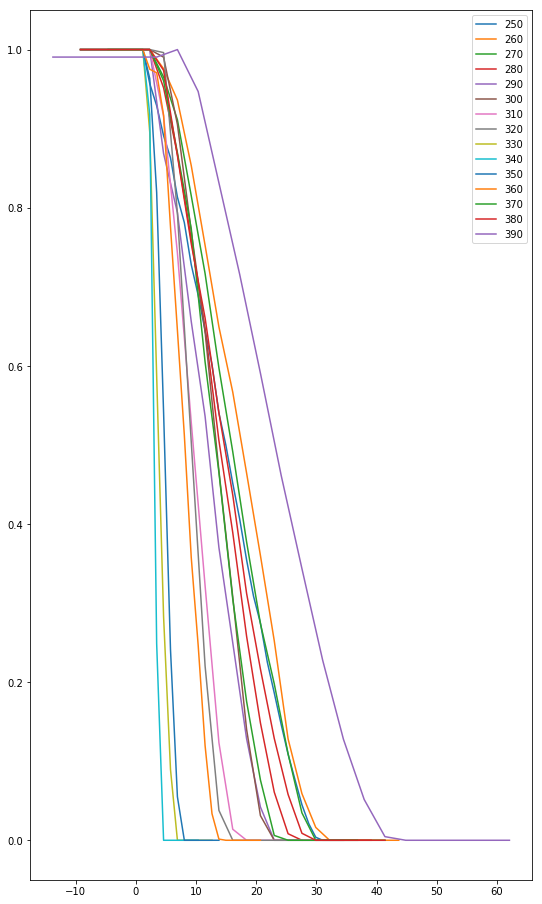

In [515]:
unique_currents=df.Current_mA.unique()
Amp=[]
X_fit=[]
Y_fit=[]
for c in unique_currents:
    temp_df=df.loc[df['Current_mA']==c].copy()
    Y=temp_df['Intensity_counts'].values
    X=temp_df['Distance_Traveled_um'].values
    
    Amp.append([c,np.max(Y)-np.min(Y)])
    pad_size=5
    Y_pad=np.pad(Y,pad_width=pad_size,mode='edge')
    X_pad=padx(X,pad_size)
    X_fit.append(X_pad)
    Y_fit.append(norm(Y_pad))
    plt.plot(X_pad,norm(Y_pad),label=c)
    plt.legend()

In [513]:
from scipy.optimize import curve_fit
def cum_gaus_comp(x,A,x0,s):
    return 1-np.cumsum(A/(2*s*(2*np.pi))*np.exp(-((x-x0)**2)/(2*s**2)))
fit=[]
params=[]
for x,y in zip(X_fit,Y_fit):
#     print(x)
    mid=np.median(y)
    superior_params, extras = curve_fit(cum_gaus_comp, x, y,
                                    p0=[.5, mid, 1])
    params.append(superior_params)
    fit.append(cum_gaus_comp(x,superior_params[0],superior_params[1],superior_params[2]))

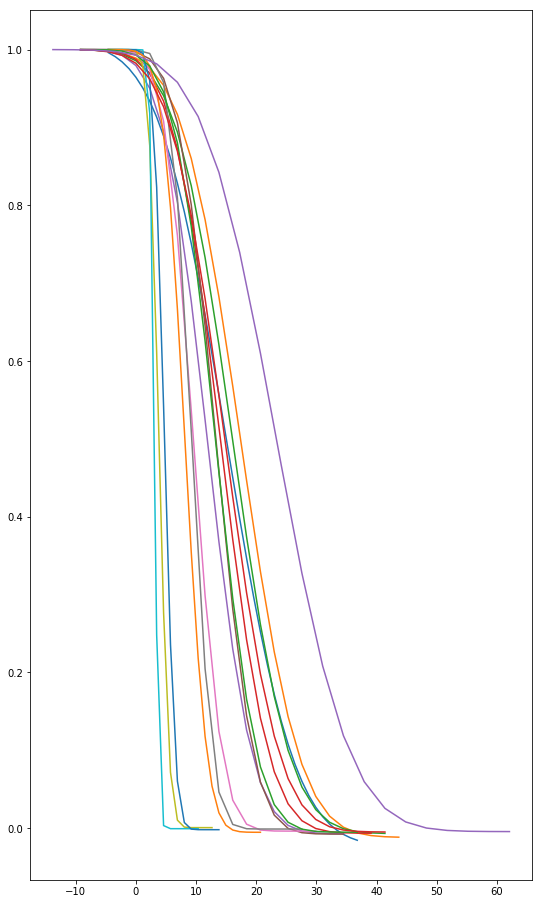

In [512]:
for n in range(len(fit)):
    plt.plot(X_fit[n],fit[n])

In [524]:
beam_waist=[]
for p in range(len(unique_currents)):
    fwhm=params[p][-1]*2*(2*np.log(2))**.5
    beam_waist.append(fwhm)
np.array(beam_waist)

array([20.9059123 , 18.03591944, 17.40808073, 14.90736284, 13.79145495,
       11.61126383,  8.91357845,  6.56627125,  3.19254421,  1.53481049,
        3.3859237 ,  6.82138968, 12.78408374, 16.64572989, 22.59758433])

In [525]:
results={'Current_mA':unique_currents,'Beam_Waist_FWHM_um':beam_waist}
df_results=pd.DataFrame(results)
df_results
    

,Current_mA,Beam_Waist_FWHM_um
0,250,20.905912
1,260,18.035919
2,270,17.408081
3,280,14.907363
4,290,13.791455
5,300,11.611264
6,310,8.913578
7,320,6.566271
8,330,3.192544
9,340,1.534810


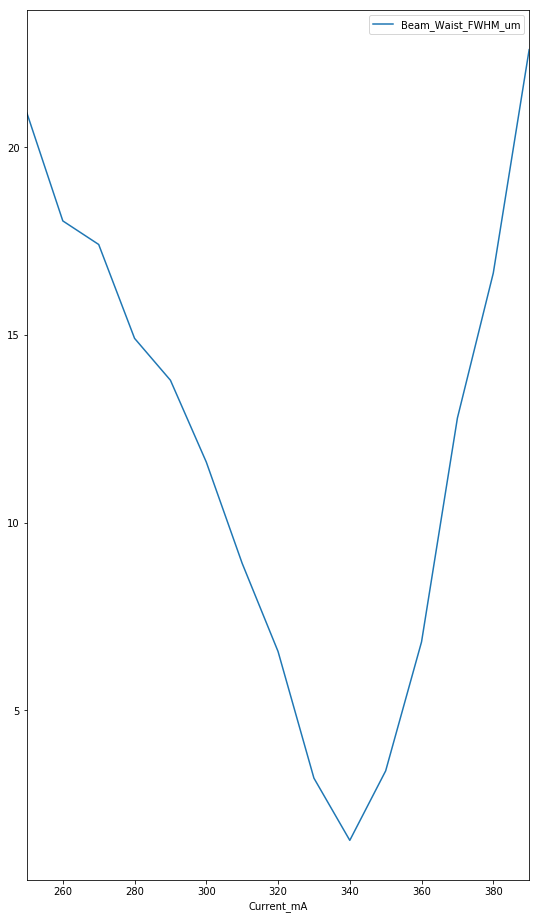

In [528]:
df_results.plot(x='Current_mA',y='Beam_Waist_FWHM_um')

### Busch's formula
Relates focal length with magnetization strength
$\frac 1 f =\int \frac{eB^2}{8m\phi}$ , $\phi = \frac{mv^2}{2e}$ this results in $\frac 1 f =\int \frac{e^2B^2}{2^2m^2v^2}$

The beam radius is given as

$w(z)=w_0 \sqrt{1+(\frac{z \lambda}{\pi w_0^2})^2}$  

where w_0 is the crossover beam size

So we can assume w_0 is a constant and we're always measuring at the same position 
If current = 340 mA puts the focal length at the aperture plane we can make a simple model  
where the beam width is given by the line connecting the C0 aperture radius to the focal point.  
We then correlate the shift in the focal point by the size of the observed beam


In [569]:
def model(f,x=None, plot=False):
    y0=1.5 #mm
    z=np.linspace(-f,f,1000)
    m=-y0/(f)
    y=np.abs(m*z)
    if plot ==True:
        return plt.plot(z,y)
    if x!=None:
        return np.abs(m*(f-x))
    return y
model(200,150)

0.375

In [575]:
apert_h=150 #mm
C0_aper_r=1.5 #mm
f=(apert_h*C0_aper_r)/(-df_results.Beam_Waist_FWHM_um.values+C0_aper_r)

In [576]:
f

array([  -11.59440466,   -13.60674263,   -14.14375523,   -16.78182374,
         -18.30540005,   -22.25241114,   -30.34971594,   -44.41136076,
        -132.93596651, -6463.56947571,  -119.30493289,   -42.28218824,
         -19.9395897 ,   -14.8556723 ,   -10.66472808])

In [542]:
from scipy.special import erf


def opp_erfunc(x, mFL, a, b):
    return .5-mFL*erf((x-a)/(b*np.sqrt(2)))
fit=[]
params=[]
for x,y in zip(X_fit,Y_fit):
#     print(x)
    mid=np.median(y)
    superior_params, extras = curve_fit(opp_erfunc, x, y,
                                    p0=[0.5, mid, 10])
    params.append(superior_params)
    fit.append(opp_erfunc(x,superior_params[0],superior_params[1],superior_params[2]))

In [333]:
tim=np.ones((40,60))
tim[10:30,20:40]=100
tim[0,0]=100
imshape=tim.shape
features=im_to_coord(tim)
tim

array([[100.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       ...,
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.]])